In [1]:
from sentinelhub import SHConfig
from dotenv import load_dotenv, find_dotenv
import os
load_dotenv(find_dotenv(filename=".env"), override=True)
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import datetime
import matplotlib.pyplot as plt
import numpy as np

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)

CLIENT_ID = os.environ.get("CLIENT_ID")
CLIENT_SECRET = os.environ.get("CLIENT_SECRET")

config = SHConfig(  
    instance_id='',
    sh_client_id=CLIENT_ID,
    sh_client_secret=CLIENT_SECRET,
    sh_base_url='https://services.sentinel-hub.com',
    sh_auth_base_url='https://services.sentinel-hub.com',
   
)


c:\Users\josue\uvg\Semestre 8\data science\Lake-Cyanobacteria-Sentinel2-Analysis\ds-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\josue\uvg\Semestre 8\data science\Lake-Cyanobacteria-Sentinel2-Analysis\ds-env\Lib\site-packages\sentinelhub\config.py:54: SHDeprecationWarning: The parameter `sh_auth_base_url` of `SHConfig` has been replaced with `sh_token_url`. Please update your configuration, for now the parameters were automatically adjusted to `sh_token_url = sh_auth_base_url + '/oauth/token'`.
  warnings.warn(
c:\Users\josue\uvg\Semestre 8\data science\Lake-Cyanobacteria-Sentinel2-Analysis\ds-env\Lib\site-packages\sentinelhub\config.py:54: SHDeprecationWarning: The parameter `sh_auth_base_url` of `SHConfig` has been replaced with `sh_token_url`. Please update your configuration, for now the parame

In [7]:
betsiboka_coords_wgs84 = (-90.638065, 14.412347, -90.512924, 14.493799) # Lake amatitlan sample
resolution = 60
betsiboka_bbox = BBox(bbox=betsiboka_coords_wgs84, crs=CRS.WGS84)
betsiboka_size = bbox_to_dimensions(betsiboka_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {betsiboka_size} pixels")


Image shape at 60 m resolution: (223, 153) pixels


2 outputs: dict_keys(['rgb.png', 'chl.tif'])
Min/Max (mg/m³): -20.283247 72.97247


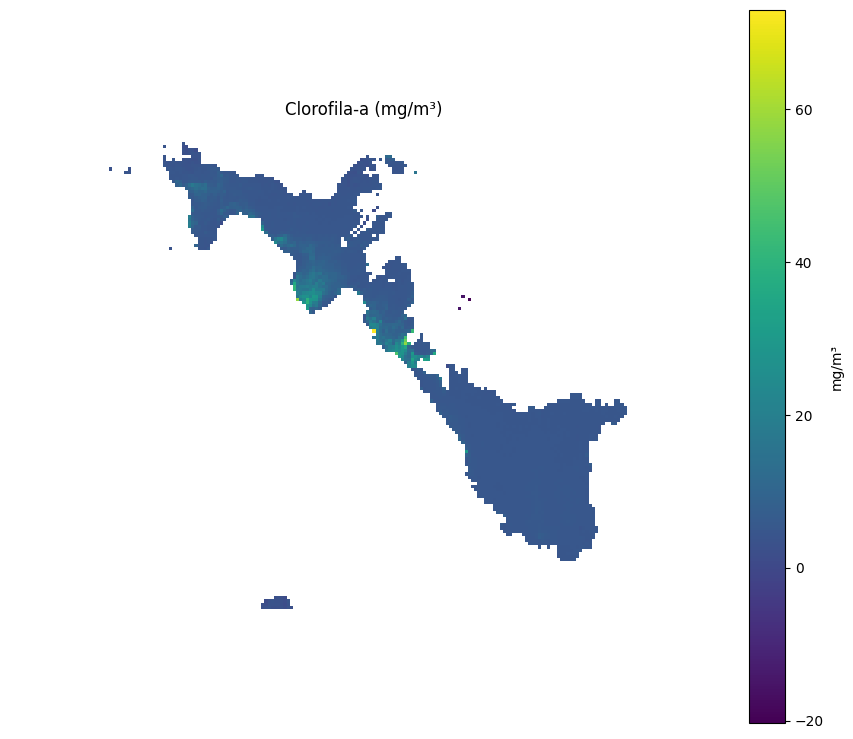

In [32]:

evalscript_cyano = """
// evalscript_both (RGB + chl)
//VERSION=3
var MNDWI_threshold=0.42, NDWI_threshold=0.4, filter_UABS=true, filter_SSI=false;

function setup() {
  return {
    input: [{ bands:["B02","B03","B04","B05","B07","B08","B8A","B11","B12"] }],
    output: [
      { id:"rgb", bands:3, sampleType:"AUTO" },
      { id:"chl", bands:1, sampleType:"FLOAT32" }
    ]
  };
}

function wbi(r,g,b,nir,swir1,swir2){
  let ws=0;
  try{
    var ndvi=(nir-r)/(nir+r), mndwi=(g-swir1)/(g+swir1), ndwi=(g-nir)/(g+nir),
        ndwi_leaves=(nir-swir1)/(nir+swir1),
        aweish=b+2.5*g-1.5*(nir+swir1)-0.25*swir2,
        aweinsh=4*(g-swir1)-(0.25*nir+2.75*swir1),
        dbsi=((swir1-g)/(swir1+g))-ndvi;
    if (mndwi>0.42||ndwi>0.4||aweinsh>0.1879||aweish>0.1112||ndvi<-0.2||ndwi_leaves>1) ws=1;
    if (filter_UABS && ws==1){ if (aweinsh<=-0.03 || dbsi>0) ws=0; }
  }catch(e){ws=0;}
  return ws;
}

function evaluatePixel(s){
  let water = wbi(s.B04,s.B03,s.B02,s.B08,s.B11,s.B12);
  let FAIv  = (s.B07 - s.B04 - (s.B8A - s.B04)*(783-665)/(865-665));
  let ndci  = (s.B05 - s.B04) / (s.B05 + s.B04);
  let chl   = 826.57*ndci**3 - 176.43*ndci**2 + 19*ndci + 4.071;

  let trueColor = [3*s.B04, 3*s.B03, 3*s.B02];
  let color;

  if (water==0) color = trueColor;
  else if (FAIv>0.08) color = [233/255,72/255,21/255];
  else if (chl<0.5)   color = [0,0,1.0];
  else if (chl<1)     color = [0,0,1.0];
  else if (chl<2.5)   color = [0,59/255,1];
  else if (chl<3.5)   color = [0,98/255,1];
  else if (chl<5)     color = [15/255,113/255,141/255];
  else if (chl<7)     color = [14/255,141/255,120/255];
  else if (chl<8)     color = [13/255,141/255,103/255];
  else if (chl<10)    color = [30/255,226/255,28/255];
  else if (chl<14)    color = [42/255,226/255,28/255];
  else if (chl<18)    color = [68/255,226/255,28/255];
  else if (chl<20)    color = [68/255,226/255,28/255];
  else if (chl<24)    color = [134/255,247/255,0];
  else if (chl<28)    color = [140/255,247/255,0];
  else if (chl<30)    color = [205/255,237/255,0];
  else if (chl<38)    color = [208/255,240/255,0];
  else if (chl<45)    color = [208/255,240/255,0];
  else if (chl<50)    color = [251/255,210/255,3/255];
  else if (chl<75)    color = [248/255,207/255,2/255];
  else if (chl<90)    color = [134/255,247/255,0];
  else if (chl<100)   color = [245/255,164/255,9/255];
  else if (chl<150)   color = [240/255,159/255,8/255];
  else if (chl<250)   color = [237/255,157/255,7/255];
  else if (chl<300)   color = [239/255,118/255,15/255];
  else if (chl<350)   color = [239/255,101/255,15/255];
  else if (chl<450)   color = [239/255,100/255,14/255];
  else if (chl<500)   color = [233/255,72/255,21/255];
  else                color = [233/255,72/255,21/255];

  // Devuelve imagen RGB y, en paralelo, el valor numérico (NaN fuera de agua)
  return {
    rgb: color,
    chl: [water ? chl : NaN]
  };
}
"""

request_both = SentinelHubRequest(
    evalscript=evalscript_cyano,
    input_data=[SentinelHubRequest.input_data(
        data_collection=DataCollection.SENTINEL2_L1C,
        time_interval=("2025-06-01", "2025-06-15"),
        mosaicking_order=MosaickingOrder.LEAST_CC
    )],
    responses=[
        SentinelHubRequest.output_response("rgb", MimeType.PNG),
        SentinelHubRequest.output_response("chl", MimeType.TIFF),
    ],
    bbox=betsiboka_bbox, size=betsiboka_size, config=config
)


out = request_both.get_data()   # dict con llaves "rgb" y "chl"
print(len(out[0].keys()), "outputs:", out[0].keys())
rgb_img = out[0]["rgb.png"]
chl_img = out[0]["chl.tif"]               # 2D, mg/m³

# Stats y ejemplo de gráfico con colorbar numérica
import numpy as np, matplotlib.pyplot as plt
print("Min/Max (mg/m³):", np.nanmin(chl_img), np.nanmax(chl_img))
plt.figure(figsize=(10,10))
im = plt.imshow(chl_img, cmap="viridis")
plt.title("Clorofila-a (mg/m³)")
plt.axis("off")
cbar = plt.colorbar(im, fraction=0.046, pad=0.04); cbar.set_label("mg/m³")
plt.show()



# B12 Band sample

In [4]:

plt.figure(figsize=(8, 6))
plt.imshow(all_bands_response[0][:, :, 12], cmap='gray')
plt.title('Band 12')
plt.colorbar()
plt.show()

NameError: name 'all_bands_response' is not defined

<Figure size 800x600 with 0 Axes>

# All Bands sample

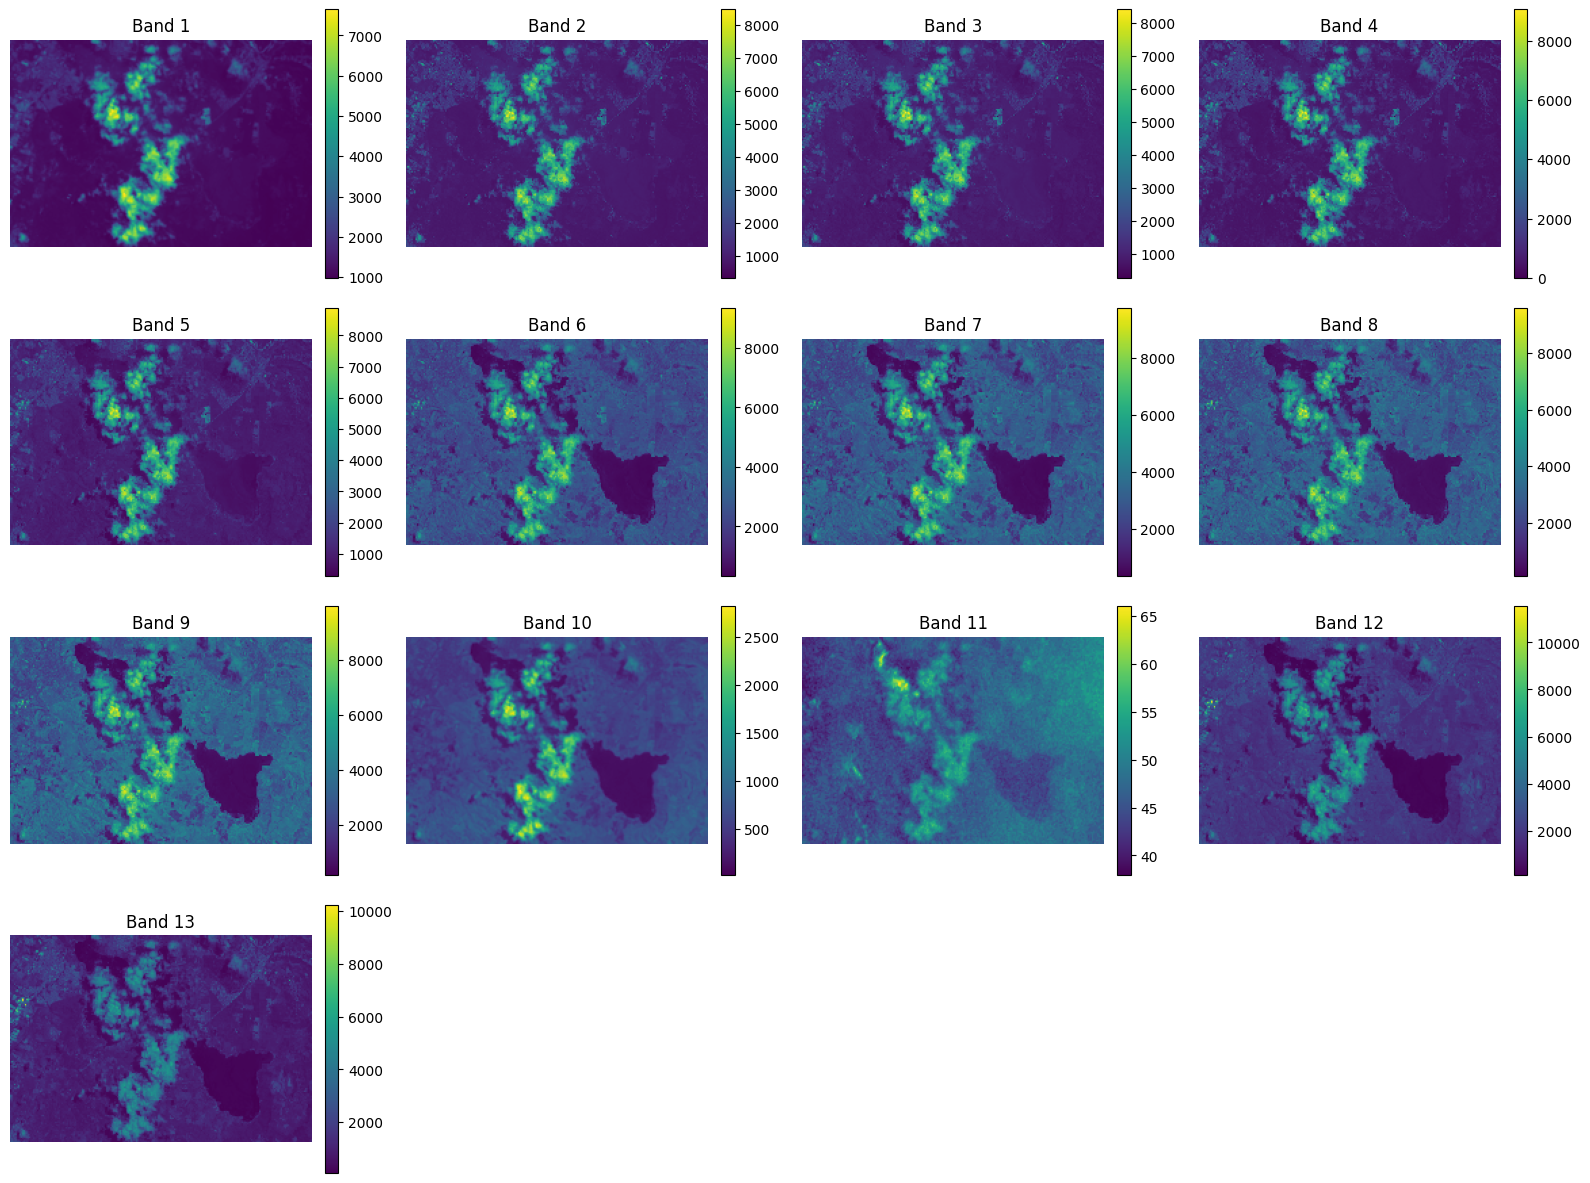

In [ ]:
# Plot all 13 bands from all_bands_response[0] in a grid
import matplotlib.pyplot as plt
import numpy as np

bands_img = all_bands_response[0]  # shape: (height, width, 13)
n_bands = bands_img.shape[2]
n_cols = 4
n_rows = int(np.ceil(n_bands / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 3 * n_rows))
axes = axes.flatten()

for i in range(n_bands):
    ax = axes[i]
    band = bands_img[:, :, i]
    im = ax.imshow(band, cmap='gray')
    ax.set_title(f'Band {i+1}')
    ax.axis('off')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Hide any unused subplots
for j in range(n_bands, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# RGB band sample

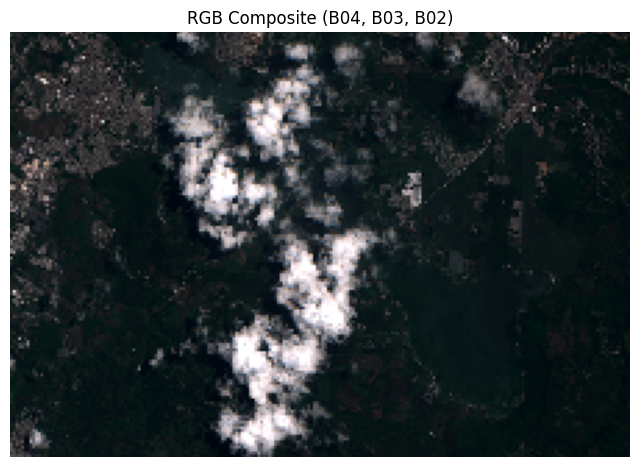

In [ ]:
# Plot RGB composite (B04, B03, B02) from all_bands_response[0]
import matplotlib.pyplot as plt
import numpy as np

bands_img = all_bands_response[0]  # shape: (height, width, 13)
# Sentinel-2: B04=red (index 3), B03=green (index 2), B02=blue (index 1)
rgb = bands_img[:, :, [3, 2, 1]].astype(float)

# Normalize for display (simple min-max normalization)
rgb_min = np.percentile(rgb, 1)
rgb_max = np.percentile(rgb, 99)
rgb = np.clip((rgb - rgb_min) / (rgb_max - rgb_min), 0, 1)

plt.figure(figsize=(8, 8))
plt.imshow(rgb)
plt.title('RGB Composite (B04, B03, B02)')
plt.axis('off')
plt.show()

# Multiple timestamps data
https://sentinelhub-py.readthedocs.io/en/latest/examples/process_request.html#Example-1:-True-color-(PNG)-on-a-specific-date

In [ ]:
start = datetime.datetime(2019, 1, 1)
end = datetime.datetime(2019, 12, 31)
n_chunks = 13
tdelta = (end - start) / n_chunks
edges = [(start + i * tdelta).date().isoformat() for i in range(n_chunks)]
slots = [(edges[i], edges[i + 1]) for i in range(len(edges) - 1)]

print("Monthly time windows:\n")
for slot in slots:
    print(slot)

Monthly time windows:

('2019-01-01', '2019-01-29')
('2019-01-29', '2019-02-26')
('2019-02-26', '2019-03-26')
('2019-03-26', '2019-04-23')
('2019-04-23', '2019-05-21')
('2019-05-21', '2019-06-18')
('2019-06-18', '2019-07-16')
('2019-07-16', '2019-08-13')
('2019-08-13', '2019-09-10')
('2019-09-10', '2019-10-08')
('2019-10-08', '2019-11-05')
('2019-11-05', '2019-12-03')


In [ ]:
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=("2020-06-12", "2020-06-13"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=betsiboka_bbox,
    size=betsiboka_size,
    config=config,
)

def get_true_color_request(time_interval):
    return SentinelHubRequest(
        evalscript=evalscript_true_color,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L1C,
                time_interval=time_interval,
                mosaicking_order=MosaickingOrder.LEAST_CC,
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
        bbox=betsiboka_bbox,
        size=betsiboka_size,
        config=config,
    )

In [ ]:
# create a list of requests
list_of_requests = [get_true_color_request(slot) for slot in slots]
list_of_requests = [request.download_list[0] for request in list_of_requests]

# download data with multiple threads
data = SentinelHubDownloadClient(config=config).download(list_of_requests, max_threads=5)

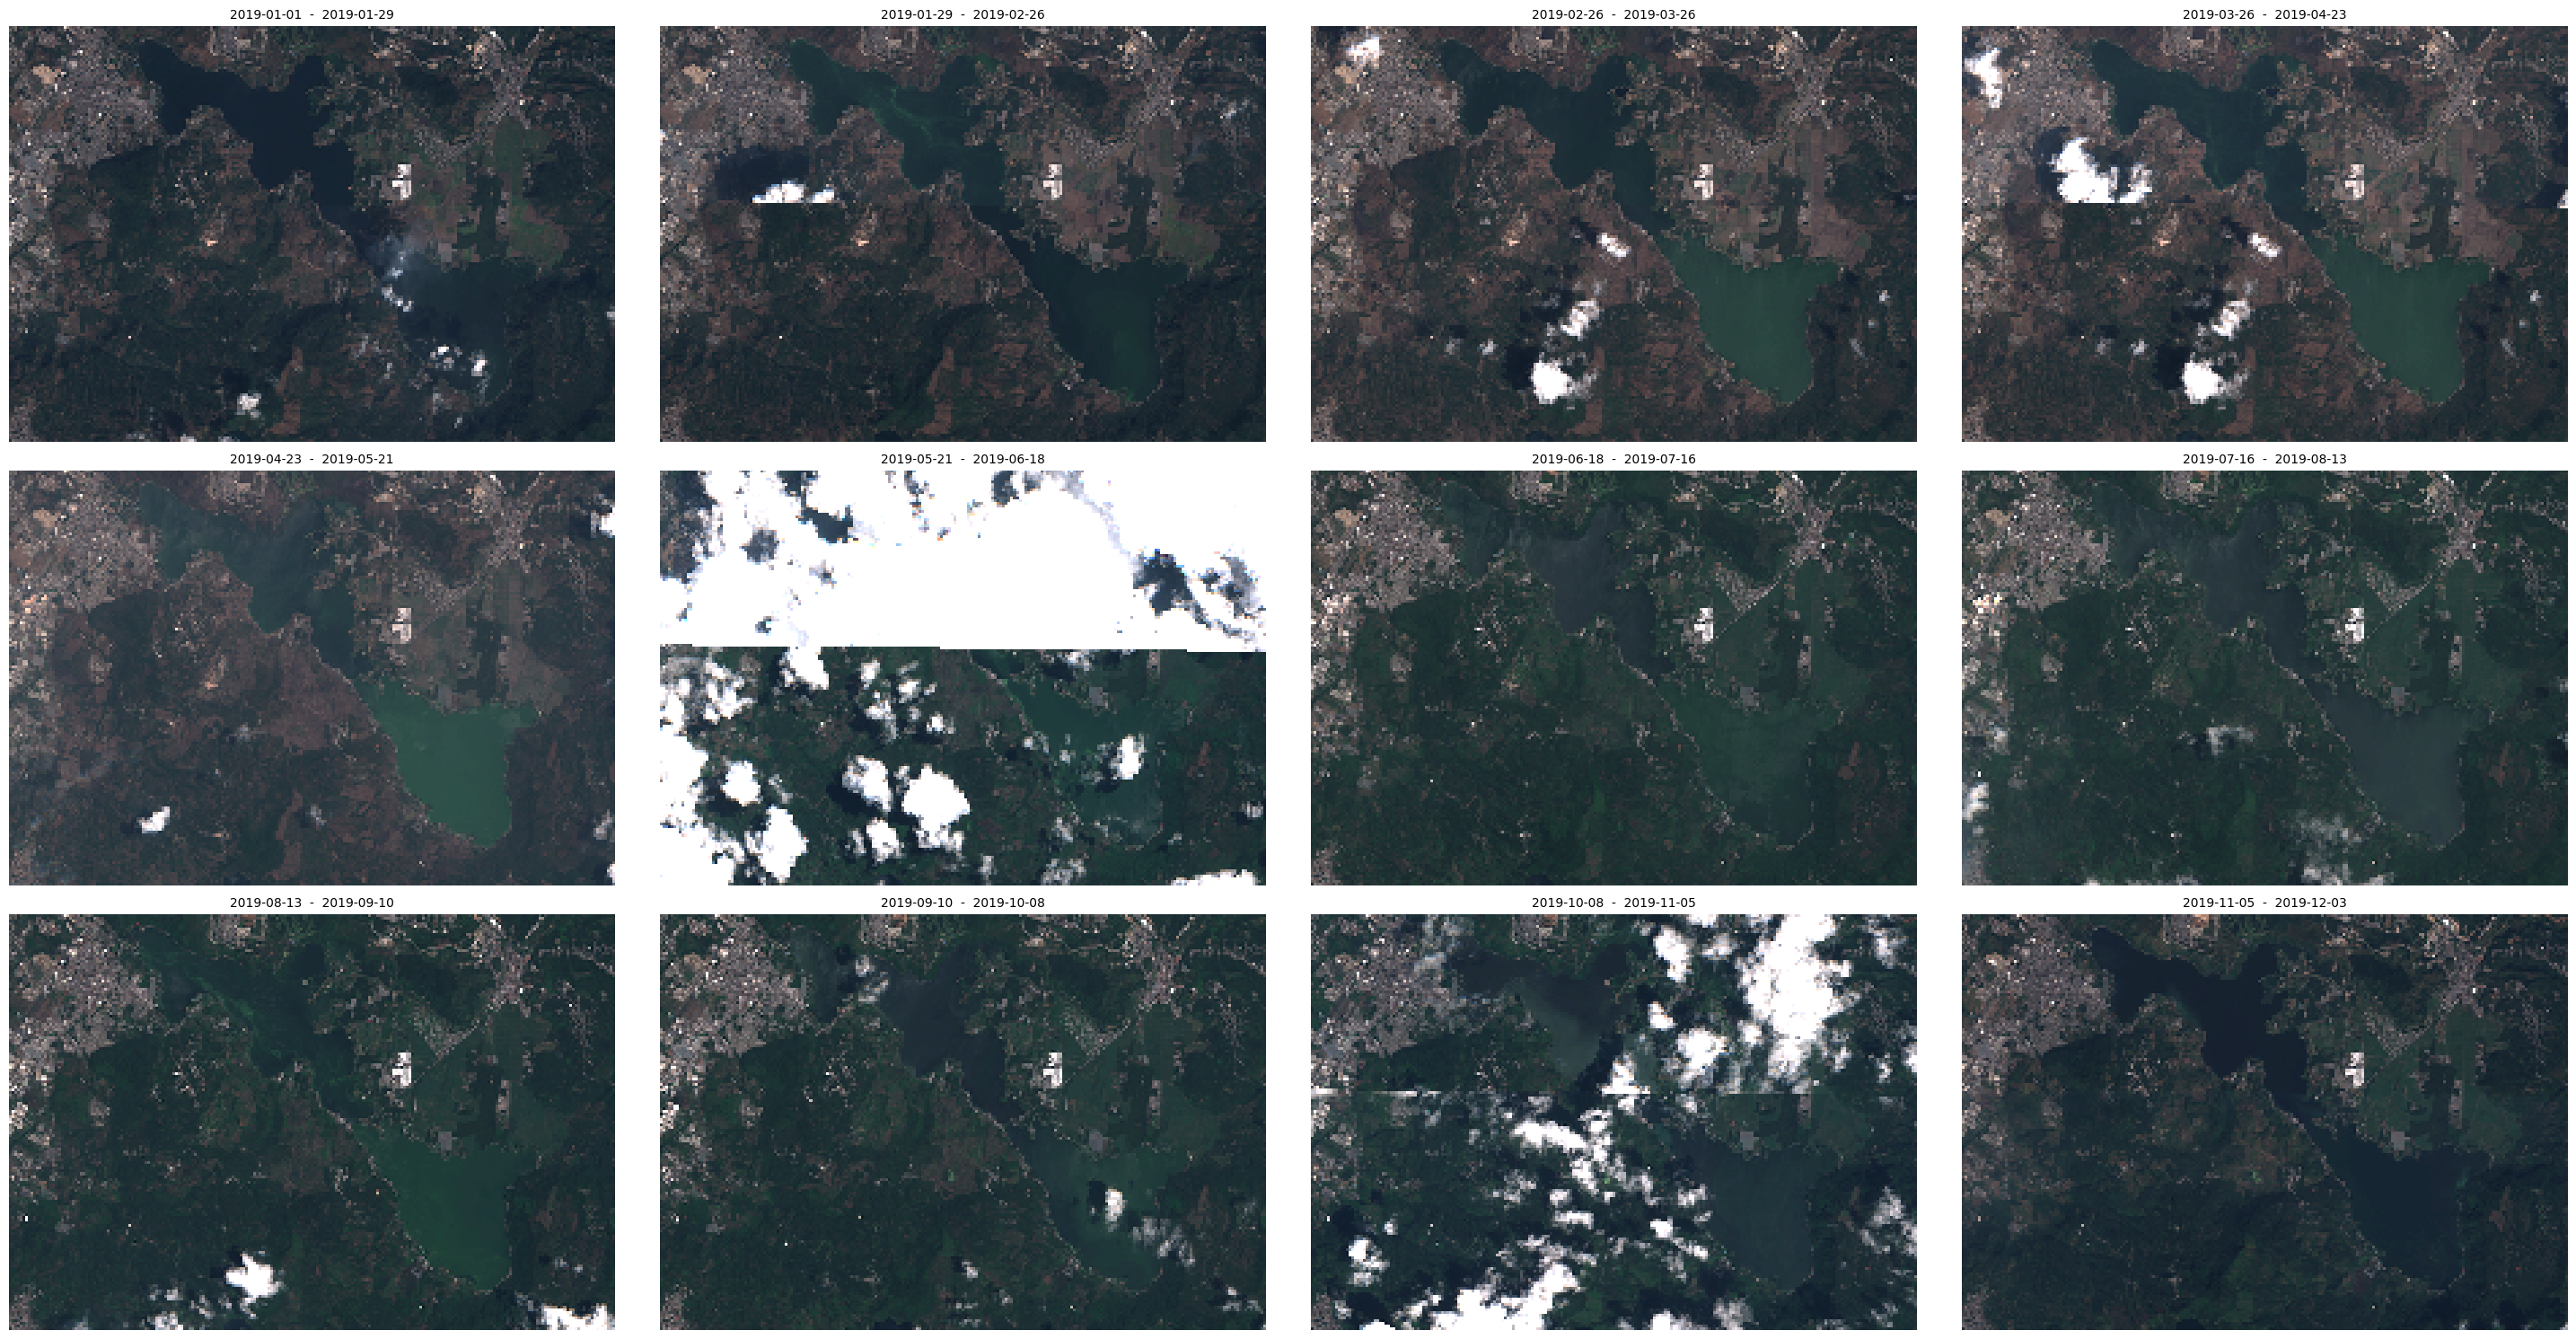

In [ ]:
# some stuff for pretty plots
ncols = 4
nrows = 3
aspect_ratio = betsiboka_size[0] / betsiboka_size[1]
subplot_kw = {"xticks": [], "yticks": [], "frame_on": False}

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5 * ncols * aspect_ratio, 5 * nrows), subplot_kw=subplot_kw)

for idx, image in enumerate(data):
    ax = axs[idx // ncols][idx % ncols]
    ax.imshow(np.clip(image * 2.5 / 255, 0, 1))
    ax.set_title(f"{slots[idx][0]}  -  {slots[idx][1]}", fontsize=10)

plt.tight_layout()